5. Read a grayscale image and perform the following operations

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def display(img_set,img_title, row, col):
    n = len(img_set)
    plt.figure(figsize=(15,10))
    for i in range(n):
        plt.subplot(row,col,i+1)
        plt.title(img_title[i])
        plt.imshow(img_set[i],cmap='gray')
    plt.tight_layout()
    plt.show()

Original Image shape : (239, 319)


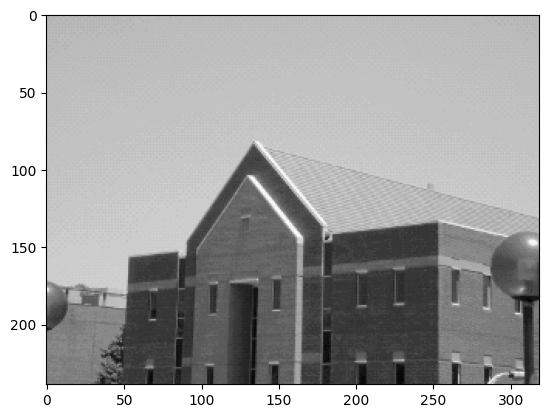

In [4]:
org_img = cv2.imread("image.png", cv2.IMREAD_GRAYSCALE)
print(f"Original Image shape : {org_img.shape}")
plt.imshow(org_img, cmap='grey')

A. Compare different edge detection algorithms implemented in spatial domain. 

In [7]:
def perform_filter_op(img, kernel):
    half_k_h, half_k_w = kernel.shape[0]//2, kernel.shape[1]//2
    padded_img = np.pad(img, ((half_k_h,half_k_h),(half_k_w,half_k_w)), mode='edge')
    filtered_img = np.zeros_like(img, dtype=np.uint8)

    #perform convolution
    for i in range(half_k_h,padded_img.shape[0]-half_k_h):
        for j in range(half_k_w,padded_img.shape[1]-half_k_w):
            region = padded_img[i-half_k_h:i+half_k_h+1, j-half_k_w:j+half_k_w+1]
            filtered_img[i-half_k_h, j-half_k_w] = np.clip(np.sum(region*kernel),0,255).astype(np.uint8)
    
    return filtered_img

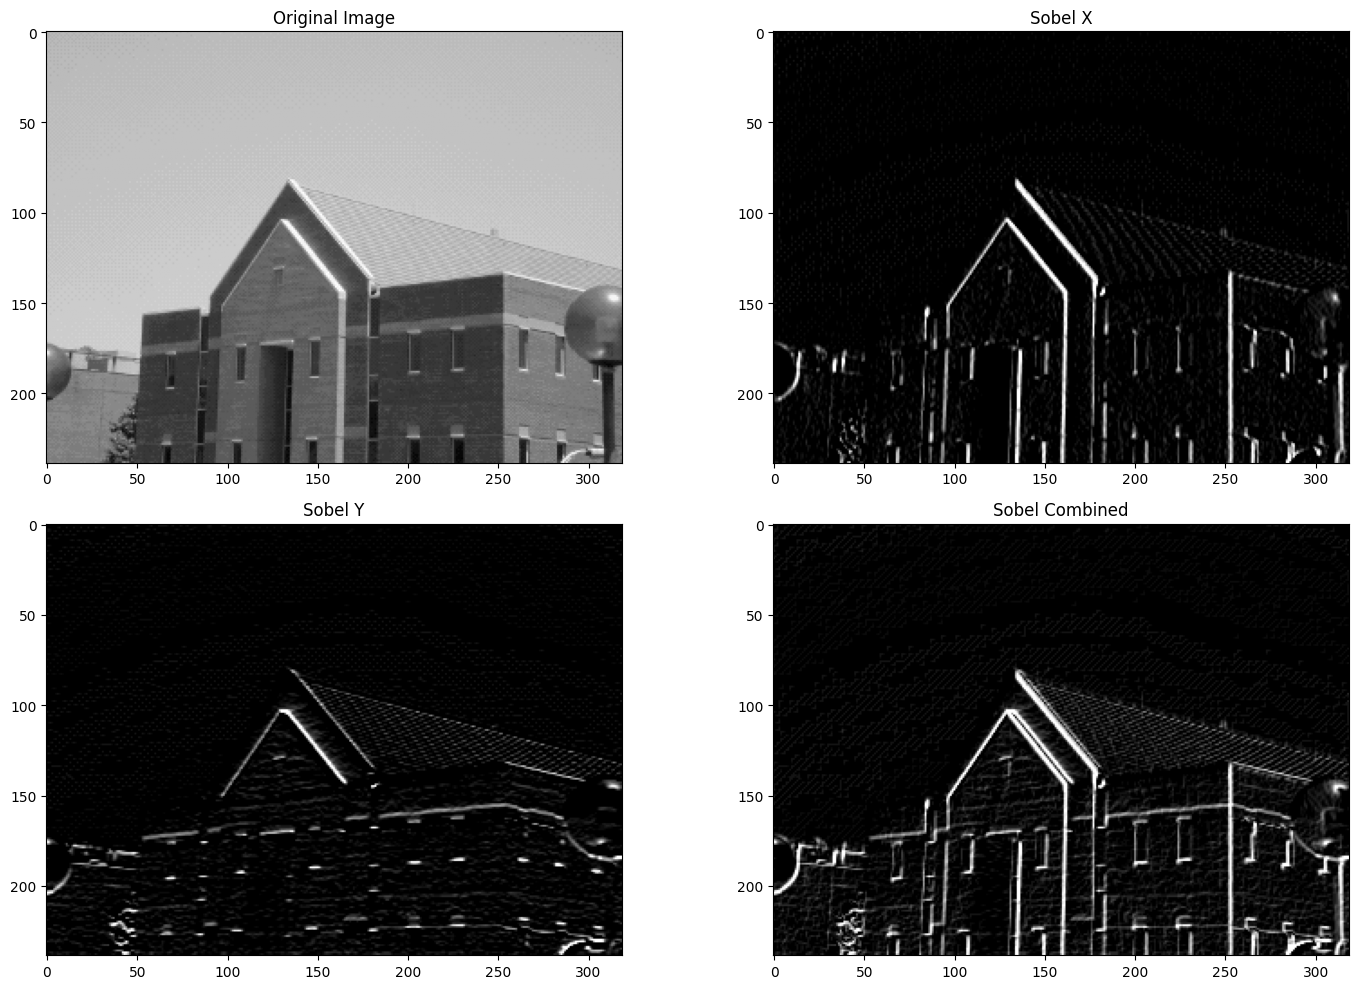

In [ ]:
# sobel operator to detect horizontal edges
sobel_operator_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
# sobel operator to detect vertical edges
sobel_operator_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

# perform convolution with sobel operator
sobel_x = perform_filter_op(org_img, sobel_operator_x)
sobel_y = perform_filter_op(org_img, sobel_operator_y)
# combine the two sobel images
sobel_combined = cv2.add(sobel_x, sobel_y)
# display the results
img_set = [org_img, sobel_x, sobel_y, sobel_combined]
img_title = ['Original Image', 'Sobel X', 'Sobel Y', 'Sobel Combined']
display(img_set, img_title, 2, 2)


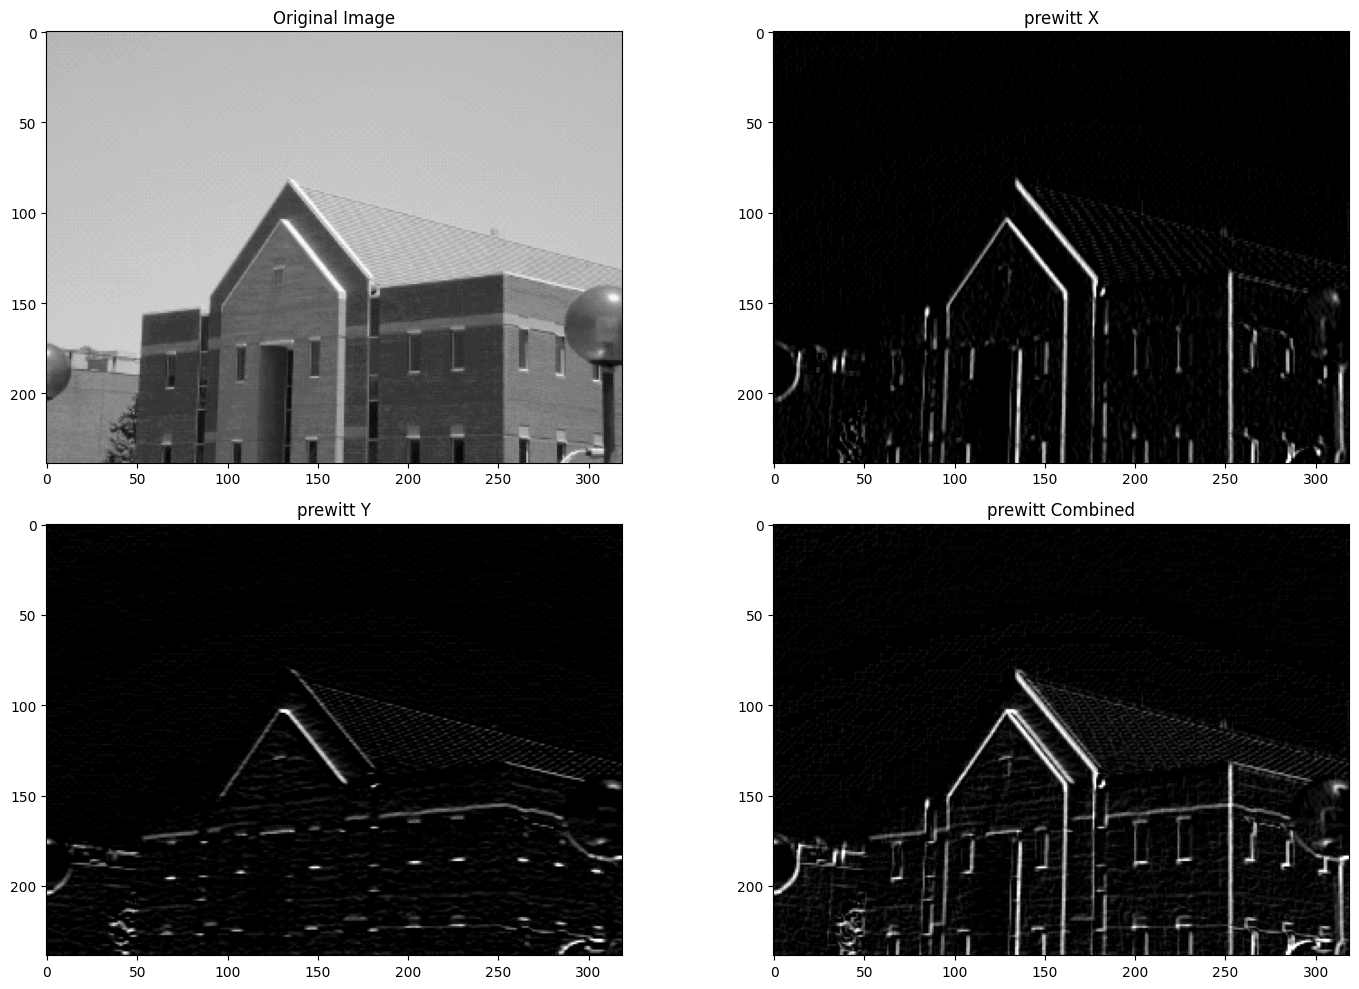

In [12]:
# prewitt operator to detect horizontal edges
prewitt_operator_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

#prewitt operator to detect vertical edges
prewitt_operator_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

#perform prewitt operation
prewitt_x = perform_filter_op(org_img,prewitt_operator_x)
prewitt_y = perform_filter_op(org_img,prewitt_operator_y)

prewitt_combine = cv2.add(prewitt_x, prewitt_y)

# display the results
img_set = [org_img, prewitt_x, prewitt_y, prewitt_combine]
img_title = ['Original Image', 'prewitt X', 'prewitt Y', 'prewitt Combined']
display(img_set, img_title, 2, 2)

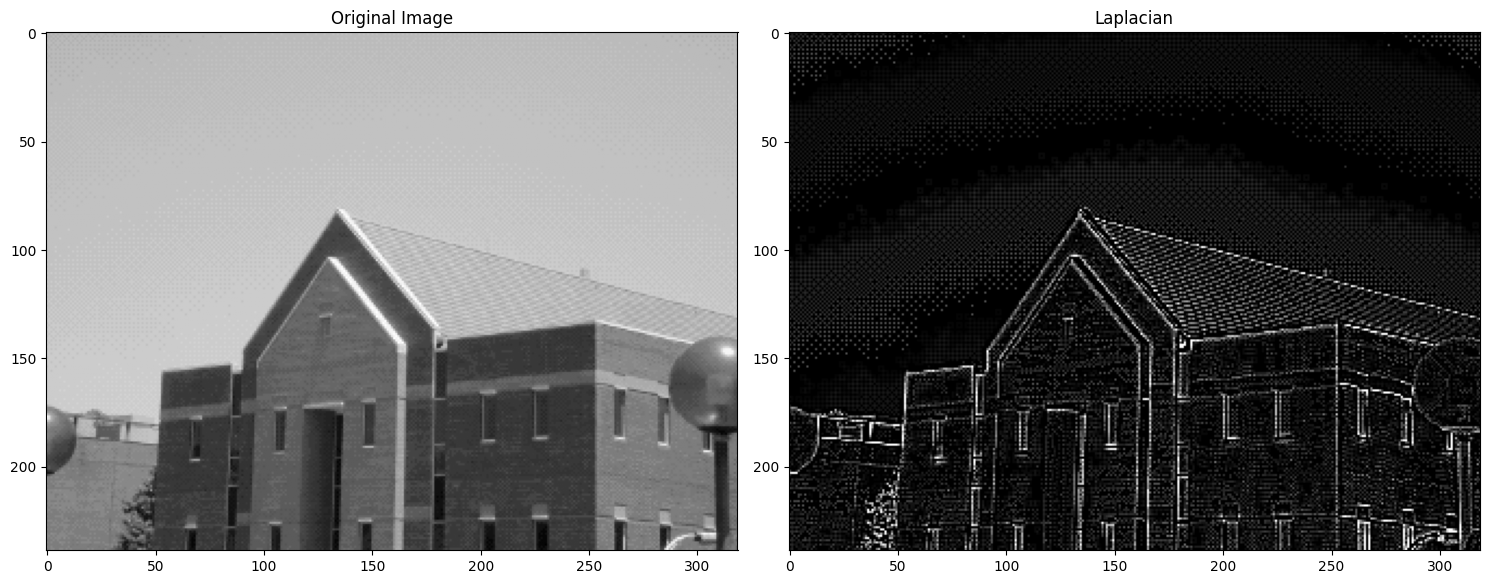

In [14]:
# Perform Laplacian operation
laplacian_operator = np.array([[1, 1, 1],
                               [1, -8, 1],
                               [1, 1, 1]])
laplacian = perform_filter_op(org_img, laplacian_operator)

# display the results
img_set = [org_img, laplacian]
img_title = ['Original Image', 'Laplacian']
display(img_set, img_title, 1, 2)

B. Illustrate the segmentation based on gray level. 

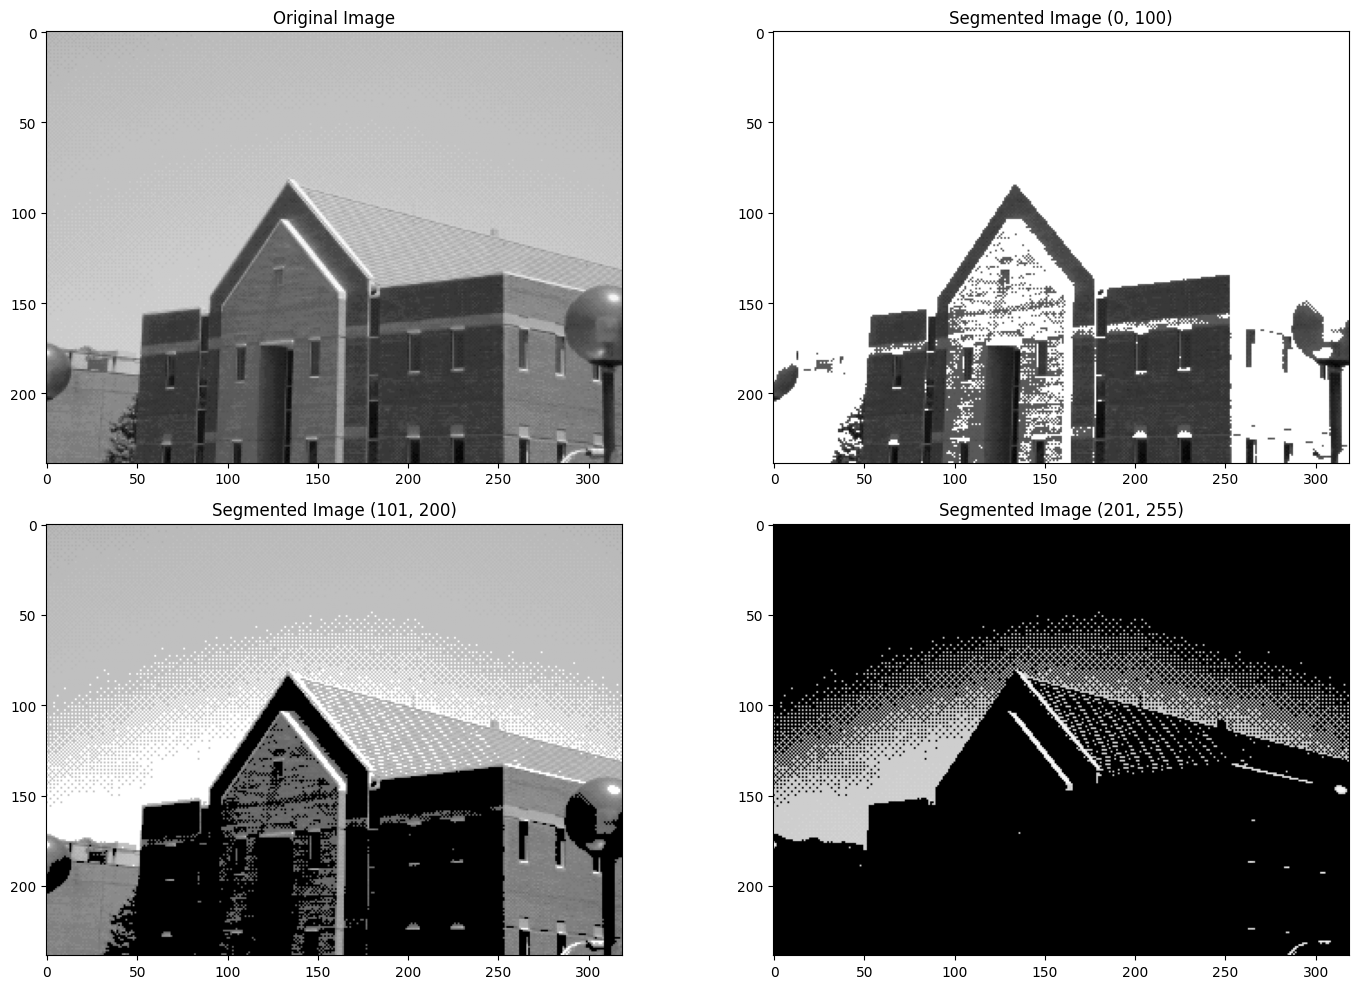

In [ ]:
def gray_level_segmentation(img, lower, upper):
    # remain the pixels in the range [lower, upper] and set others which are lower than lower to 0 and others which are greater than upper to 255
    segmented_img = img.copy()
    segmented_img[img < lower] = 0
    segmented_img[img > upper] = 255

    return segmented_img


# Perform gray level segmentation
lower = [0, 101, 201]
upper = [100, 200, 255]
segmented_img_set = [gray_level_segmentation(org_img, lower[i], upper[i]) for i in range(len(lower))]

# display the results
img_set = [org_img] + segmented_img_set
img_title = ['Original Image'] + [f'Segmented Image {lower[i],upper[i]}' for i in range(len(lower))]
display(img_set, img_title, 2, 2)

C. Implement image segmentation using basic global thresholding algorithm

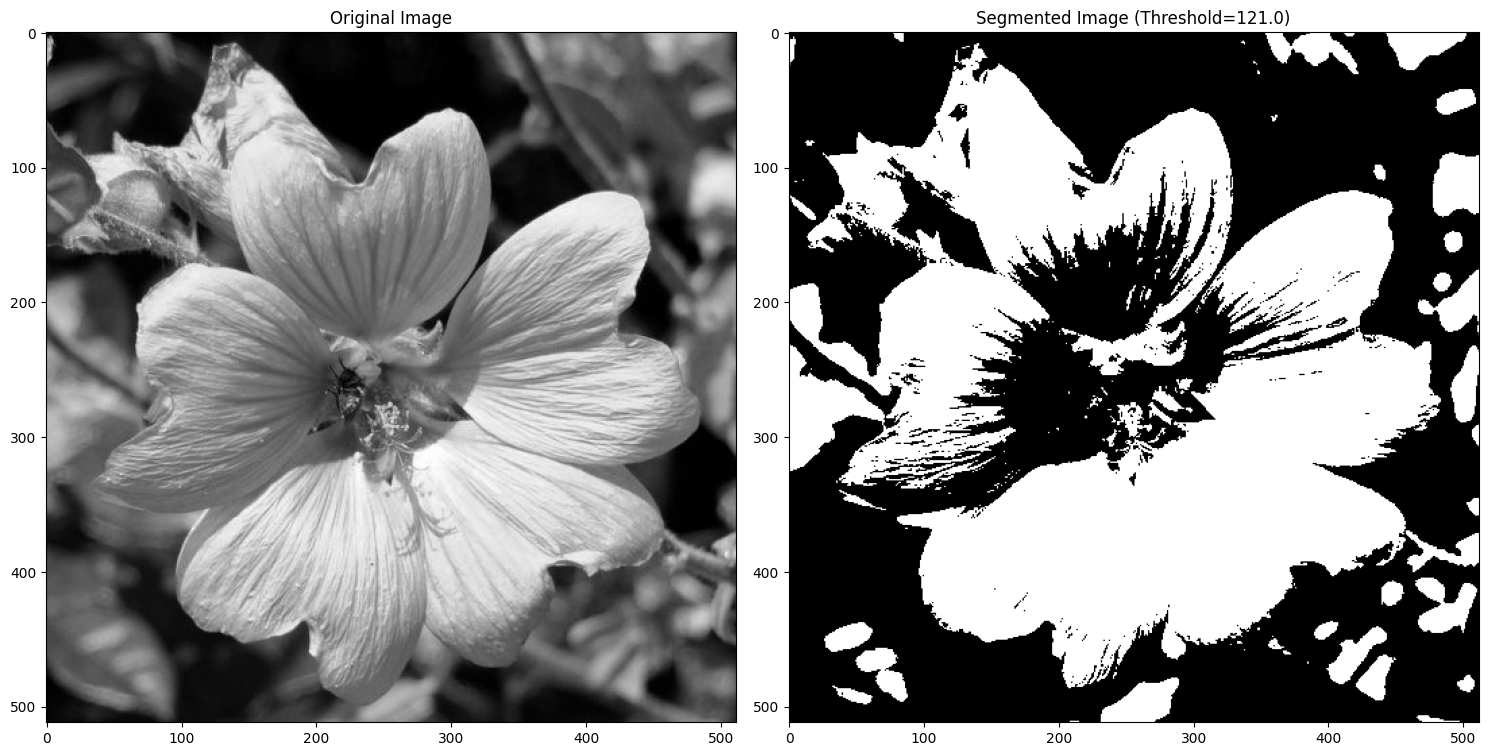

In [28]:
def find_global_threshold(img):
    tolerance = 1
    threshold = 128   # initial threshold value
    max_iteration = 100
    for _ in range(max_iteration):
        # Seperate into two image
        lower_grp = img[img <= threshold]
        upper_grp = img[img > threshold]

        # Calculate the mean of each grp
        lower_mean = lower_grp.mean() if len(lower_grp) > 0 else 0
        upper_mean = upper_grp.mean() if len(upper_grp) > 0 else 0

        # Calculate the new threshold
        newThreshold = (lower_mean + upper_mean) // 2

        # checking for convergence
        if abs(newThreshold-threshold) < tolerance:
            break

        threshold = newThreshold
    
    return threshold

def global_thresholding(img, threshold):
    # Create a binary image based on the threshold
    segmented_img = np.zeros_like(img, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > threshold:
                segmented_img[i, j] = 255
            else:
                segmented_img[i, j] = 0
    return segmented_img

# Load another image
org_img2 = cv2.imread('flower.bmp',cv2.IMREAD_GRAYSCALE)

# Perform global thresholding
threshold = find_global_threshold(org_img2)
segmented_img = global_thresholding(org_img2, threshold)

# Display the results
img_set = [org_img2, segmented_img]
img_title = ['Original Image', f'Segmented Image (Threshold={threshold})']
display(img_set, img_title, 1, 2)

D. Demonstrate the segmentation by adaptive thresholding. 

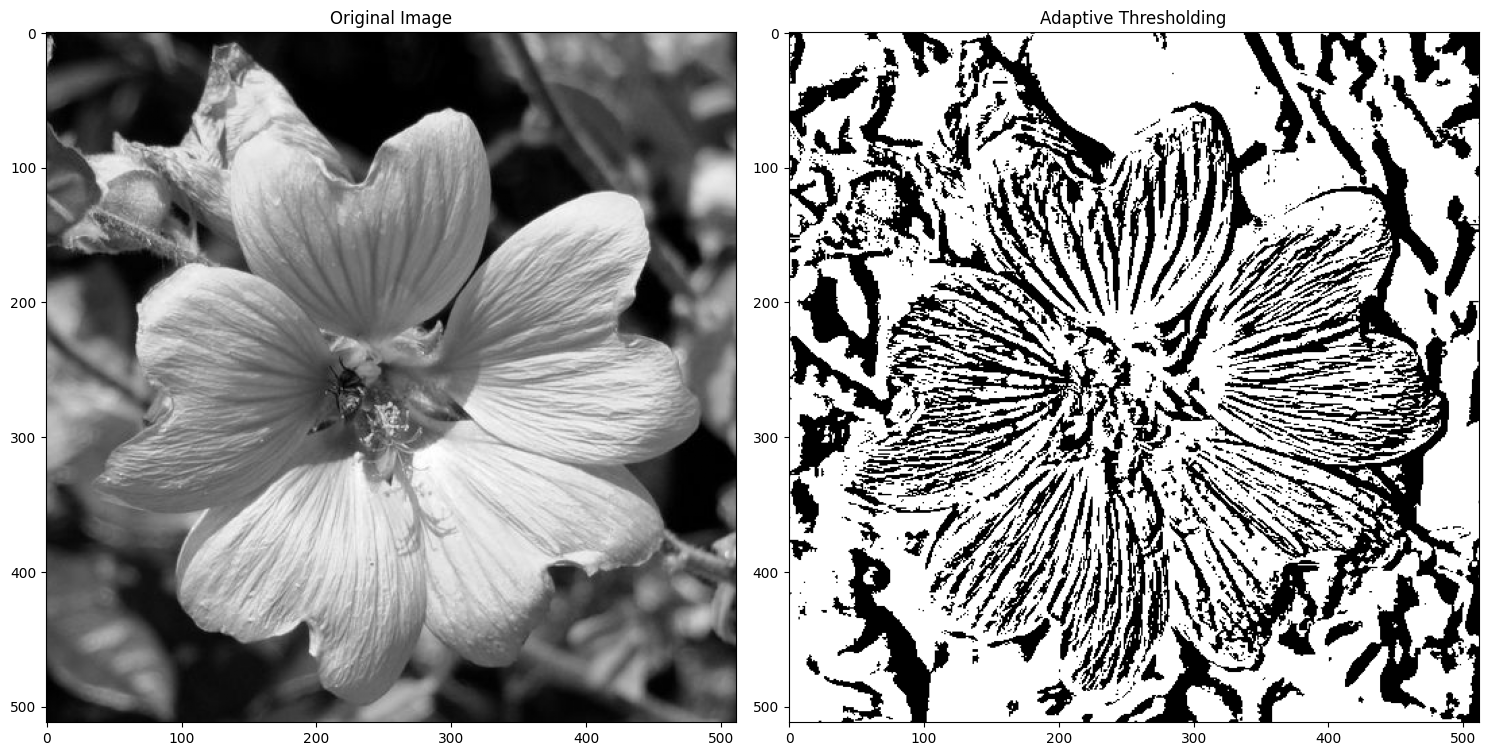

In [39]:
def adaptive_thresholding(img, block_size, C):
    """
    Perform adaptive thresholding on the input image.
    :param img: Input grayscale image (numpy.ndarray)
    :param block_size: Size of the local region (must be odd)
    :param C: Constant to subtract from the mean
    :return: Thresholded binary image
    """
    if block_size % 2 == 0:
        raise ValueError("Block Size must be odd")
    
    threshold_img = np.zeros_like(img, dtype=np.uint8)
    h_blk_size = block_size//2
    padded_img = np.pad(img, h_blk_size, mode='edge')

    for i in range(h_blk_size, padded_img.shape[0]-h_blk_size):
        for j in range(h_blk_size, padded_img.shape[1] - h_blk_size):
            local_region = padded_img[i-h_blk_size:i+h_blk_size+1, j-h_blk_size:j-h_blk_size+1]
            local_mean = np.mean(local_region)
            if img[i-h_blk_size,j-h_blk_size] > (local_mean-C):
                threshold_img[i-h_blk_size,j-h_blk_size] = 255
            else:
                threshold_img[i-h_blk_size,j-h_blk_size] = 0
    
    return threshold_img

# Perform adaptive thresholding
block_size = 9  # Must be odd
C = 5
adaptive_thresh_img = adaptive_thresholding(org_img2, block_size, C)

# Display the results
img_set = [org_img2, adaptive_thresh_img]
img_title = ['Original Image', 'Adaptive Thresholding']
display(img_set, img_title, 1, 2)